# CS5830 Project 5: Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Models
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Caden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Download dataset from https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
df = pd.read_csv('data/WELFake_Dataset.csv', index_col=0)
df = df.dropna()
df

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [3]:
### FUNCTIONS ###

def get_scores(y_label, y_pred):
    precision, recall, f1score, support = precision_recall_fscore_support(
        y_label, y_pred, average='binary', pos_label=1
    ) # average='binary', pos_label=1 == Only report scores for ability to predict real news

    print(f'Precision: {round(precision, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'f1-score: {round(f1score, 4)}')


def print_confusion_matrix(y_label, y_pred):
    confusion_matrix = pd.crosstab(y_label, y_pred, rownames=['Actual'], colnames=['Predicted'])
    percent_matrix = confusion_matrix / confusion_matrix.sum().sum()
    percent_matrix = np.round(percent_matrix*100, 2).astype(str) + '%'
    nums_and_percents = confusion_matrix.astype(str) + '\n(' + percent_matrix + ')'

    sns.heatmap(confusion_matrix, annot=nums_and_percents, fmt='', cmap='Oranges', )


def get_news_probs(mnb: MultinomialNB, cv: CountVectorizer, X_train: np.ndarray, col_title: str):
    vocabulary = cv.get_feature_names_out()

    coefficients = mnb.feature_log_prob_
    fake_news_prob = np.exp(coefficients[0])
    real_news_prob = np.exp(coefficients[1])

    fake_news_prob = pd.Series(fake_news_prob, index=vocabulary) # Probability of each word given a fake news article
    real_news_prob = pd.Series(real_news_prob, index=vocabulary) # Probability of each word given a real news article
    diff = fake_news_prob - real_news_prob
    fake_or_real = np.where(diff > 0, 'Fake', 'Real')
    occurrences = X_train.sum(axis=0)
    occurrences = np.array(occurrences).flatten()

    return pd.DataFrame({
        f'P(word | Fake {col_title.capitalize()})': fake_news_prob,
        f'P(word | Real {col_title.capitalize()})': real_news_prob,
        'Difference': diff,
        'More Likely': fake_or_real,
        'Occurrences': occurrences
    })

<53652x27783 sparse matrix of type '<class 'numpy.int64'>'
	with 479303 stored elements in Compressed Sparse Row format>

Precision: 0.883
Recall: 0.893
f1-score: 0.888


Text(0.5, 1.0, 'Article Title Confusion Matrix')

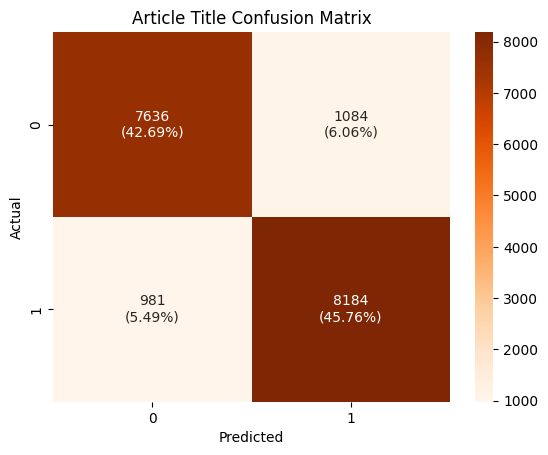

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[['title', "text"]], df['label'])

# Use count vectorizor for title
cv = CountVectorizer(stop_words=stopwords.words('english'))
X_train_counts = cv.fit_transform(X_train["title"])
X_test_counts = cv.transform(X_test["title"])
display(X_train_counts)

mnb = MultinomialNB()
mnb.fit(X_train_counts, y_train)
y_pred_title = mnb.predict(X_test_counts)

get_scores(y_test, y_pred_title)
print_confusion_matrix(y_test, y_pred_title)
plt.title('Article Title Confusion Matrix')

In [5]:
news_probs_title = get_news_probs(mnb, cv, X_train_counts, "title")

sorted_occurring = news_probs_title.sort_values(by='Occurrences', ascending=False)
most_occurring_real = sorted_occurring[sorted_occurring['More Likely'] == 'Real'][0:10]
most_occurring_fake = sorted_occurring[sorted_occurring['More Likely'] == 'Fake'][0:10]

display(most_occurring_real)
display(most_occurring_fake)

,P(word | Fake Title),P(word | Real Title),Difference,More Likely,Occurrences
trump,0.026081,0.028978,-0.002896,Real,14927
video,0.000552,0.023008,-0.022457,Real,6883
obama,0.003765,0.007739,-0.003974,Real,3196
hillary,0.001339,0.009730,-0.008391,Real,3182
clinton,0.004032,0.006085,-0.002053,Real,2777
president,0.002511,0.003522,-0.001010,Real,1650
watch,0.000442,0.005199,-0.004757,Real,1632
donald,0.002795,0.003116,-0.000321,Real,1601
election,0.002260,0.002813,-0.000553,Real,1380
news,0.001152,0.003447,-0.002295,Real,1293


,P(word | Fake Title),P(word | Real Title),Difference,More Likely,Occurrences
new,0.023631,0.003794,0.019837,Fake,6936
york,0.019886,0.000372,0.019515,Fake,5009
times,0.019525,0.000624,0.018902,Fake,4994
says,0.010199,0.001947,0.008252,Fake,3083
house,0.005554,0.001725,0.003829,Fake,1873
breitbart,0.007205,0.000136,0.007069,Fake,1814
white,0.003416,0.002656,0.000760,Fake,1619
russia,0.003623,0.002185,0.001437,Fake,1532
state,0.003022,0.001640,0.001383,Fake,1224
bill,0.002775,0.001776,0.000999,Fake,1203


Precision: 0.9113
Recall: 0.8813
f1-score: 0.8961


Text(0.5, 1.0, 'Article Text Confusion Matrix')

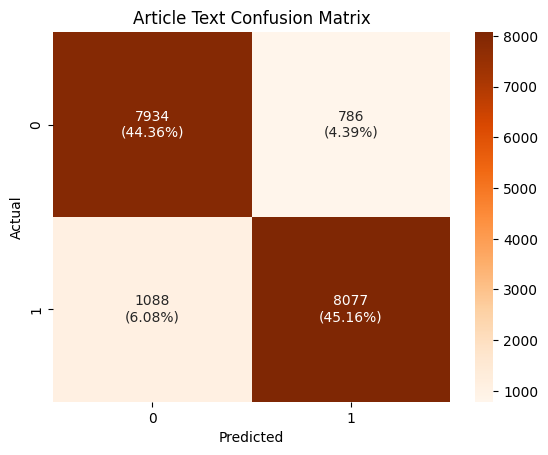

In [6]:
X_train_counts = cv.fit_transform(X_train["text"])
X_test_counts = cv.transform(X_test["text"])

mnb.fit(X_train_counts, y_train)
y_pred_text = mnb.predict(X_test_counts)

get_scores(y_test, y_pred_text)
print_confusion_matrix(y_test, y_pred_text)
plt.title('Article Text Confusion Matrix')

In [7]:
news_probs_text = get_news_probs(mnb, cv, X_train_counts, "text")

sorted_occurring = news_probs_text.sort_values(by='Occurrences', ascending=False)
most_occurring_real = sorted_occurring[sorted_occurring['More Likely'] == 'Real'][0:10]
most_occurring_fake = sorted_occurring[sorted_occurring['More Likely'] == 'Fake'][0:10]

display(most_occurring_real)
display(most_occurring_fake)

,P(word | Fake Text),P(word | Real Text),Difference,More Likely,Occurrences
trump,0.009024,0.009675,-0.000651,Real,160296
people,0.003501,0.004442,-0.000941,Real,67871
one,0.003596,0.004162,-0.000566,Real,66406
clinton,0.002367,0.004130,-0.001763,Real,55194
like,0.002090,0.002894,-0.000804,Real,42523
obama,0.001898,0.002626,-0.000729,Real,38592
time,0.001953,0.002377,-0.000424,Real,37021
us,0.000867,0.003163,-0.002296,Real,33838
even,0.001480,0.002356,-0.000876,Real,32644
donald,0.001480,0.002273,-0.000793,Real,31955


,P(word | Fake Text),P(word | Real Text),Difference,More Likely,Occurrences
said,0.015534,0.004533,0.011001,Fake,175849
would,0.005251,0.003898,0.001353,Fake,78974
president,0.004295,0.003547,0.000748,Fake,67553
mr,0.005540,0.000578,0.004963,Fake,54140
new,0.003570,0.002590,0.000980,Fake,53190
also,0.003068,0.002593,0.000474,Fake,48747
state,0.003249,0.002323,0.000926,Fake,48134
states,0.002646,0.001753,0.000893,Fake,38047
government,0.002528,0.001856,0.000672,Fake,37853
could,0.002489,0.001818,0.000671,Fake,37194


Precision: 0.8551
Recall: 0.959
f1-score: 0.9041


Text(0.5, 1.0, 'Combined Confusion Matrix')

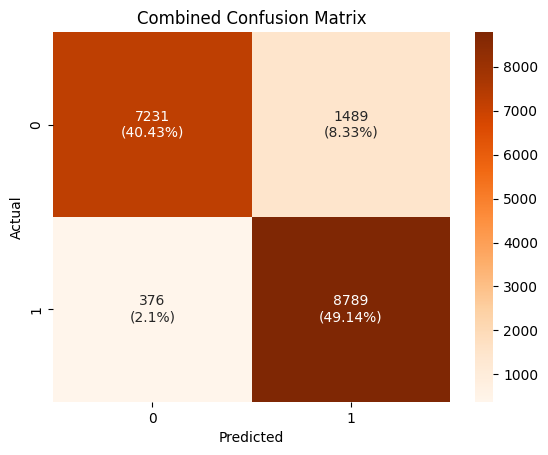

In [8]:
# Vote using a simple logical OR
y_pred_combined = y_pred_title | y_pred_text
get_scores(y_test, y_pred_combined)
print_confusion_matrix(y_test, y_pred_combined)
plt.title('Combined Confusion Matrix')